<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score, roc_auc_score

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [2]:
!wget https://archive.ics.uci.edu/static/public/159/magic+gamma+telescope.zip && unzip -q magic+gamma+telescope.zip

--2024-03-03 21:13:42--  https://archive.ics.uci.edu/static/public/159/magic+gamma+telescope.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘magic+gamma+telescope.zip’

magic+gamma+telesco     [  <=>               ] 631.48K  2.51MB/s    in 0.2s    

2024-03-03 21:13:43 (2.51 MB/s) - ‘magic+gamma+telescope.zip’ saved [646639]



In [3]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("/content/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [4]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [5]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [6]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [7]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [8]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

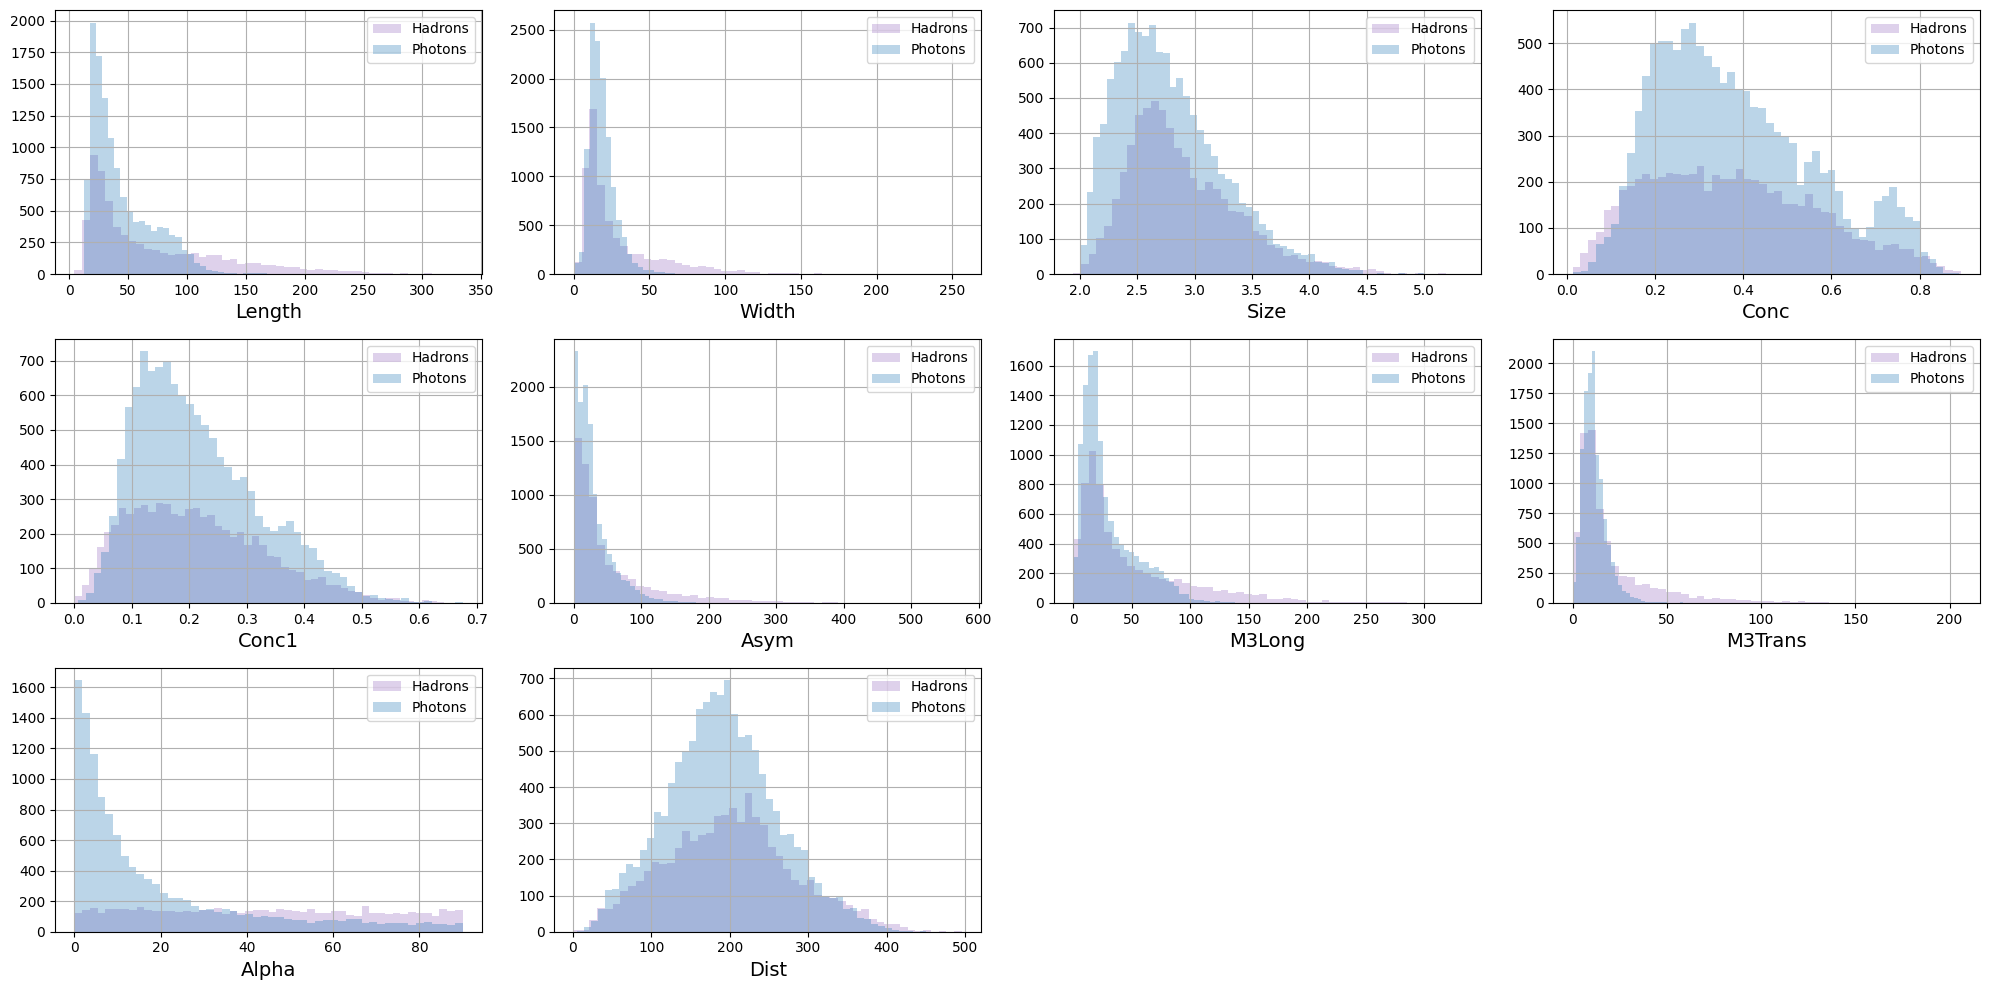

In [9]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [10]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=666
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

In [11]:
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9
count,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000
mean,53.183745,22.186768,2.829156,0.378931,0.213842,37.556063,37.261196,14.710119,27.667564,194.391876
std,42.150218,18.256096,0.474326,0.182618,0.110502,45.612626,36.206558,14.635640,26.154488,75.158047
min,4.283500,0.000000,1.941300,0.015800,0.000800,0.000000,0.000000,0.000000,0.000000,5.544900
25%,24.412600,11.900875,2.478700,0.234500,0.127500,11.079750,14.442300,7.375700,5.507925,142.350250
50%,37.179750,17.221000,2.744300,0.352750,0.195300,23.011650,23.423750,10.925400,17.726500,192.571000
75%,70.076900,24.845175,3.108050,0.501075,0.283975,46.045100,50.017350,16.245325,45.644000,241.961550
max,334.177000,256.382000,5.146700,0.875700,0.675200,473.065400,331.780000,205.894700,90.000000,495.561000


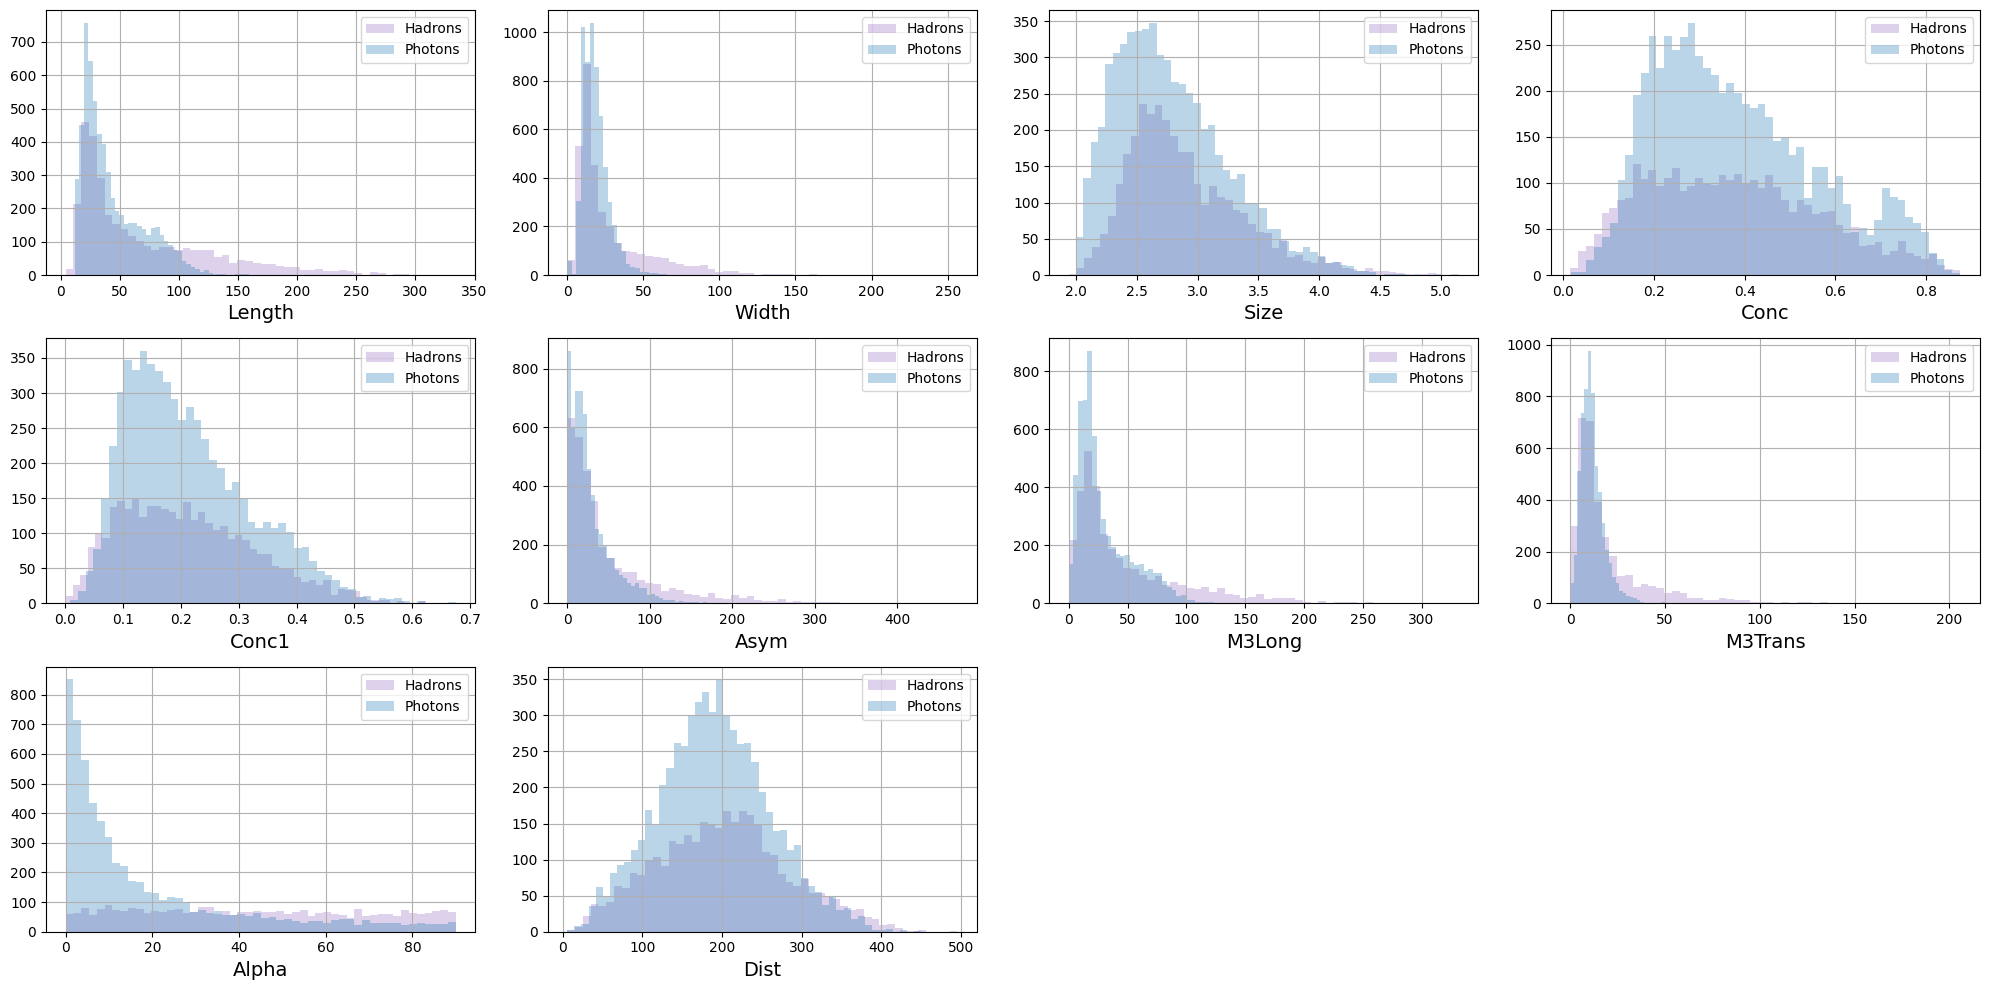

In [12]:
plot_hists(
    X_train[y_train[:, 0] == 0], X_train[y_train[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

In [13]:
pd.DataFrame(X_test).describe()

,0,1,2,3,4,5,6,7,8,9
count,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000,9510.000000
mean,53.316563,22.175165,2.820878,0.381723,0.215473,37.453562,37.392034,14.754050,27.623849,193.244177
std,42.580523,18.436536,0.470854,0.183007,0.110520,46.417470,36.427588,14.812750,26.054011,74.302602
min,7.360600,0.000000,1.946800,0.013100,0.000300,0.000000,0.000000,0.000000,0.000000,1.282600
25%,24.273925,11.825400,2.474975,0.237625,0.129700,10.812775,14.320650,7.294525,5.589750,142.585875
50%,37.121000,17.069400,2.736000,0.355300,0.198100,22.813200,23.586000,10.867700,17.630200,191.060200
75%,70.175025,24.631475,3.093750,0.506300,0.286700,46.085350,49.329275,16.169425,46.077000,238.667500
max,305.324000,220.514400,5.323300,0.893000,0.643000,575.240700,293.176200,179.851000,90.000000,466.407800


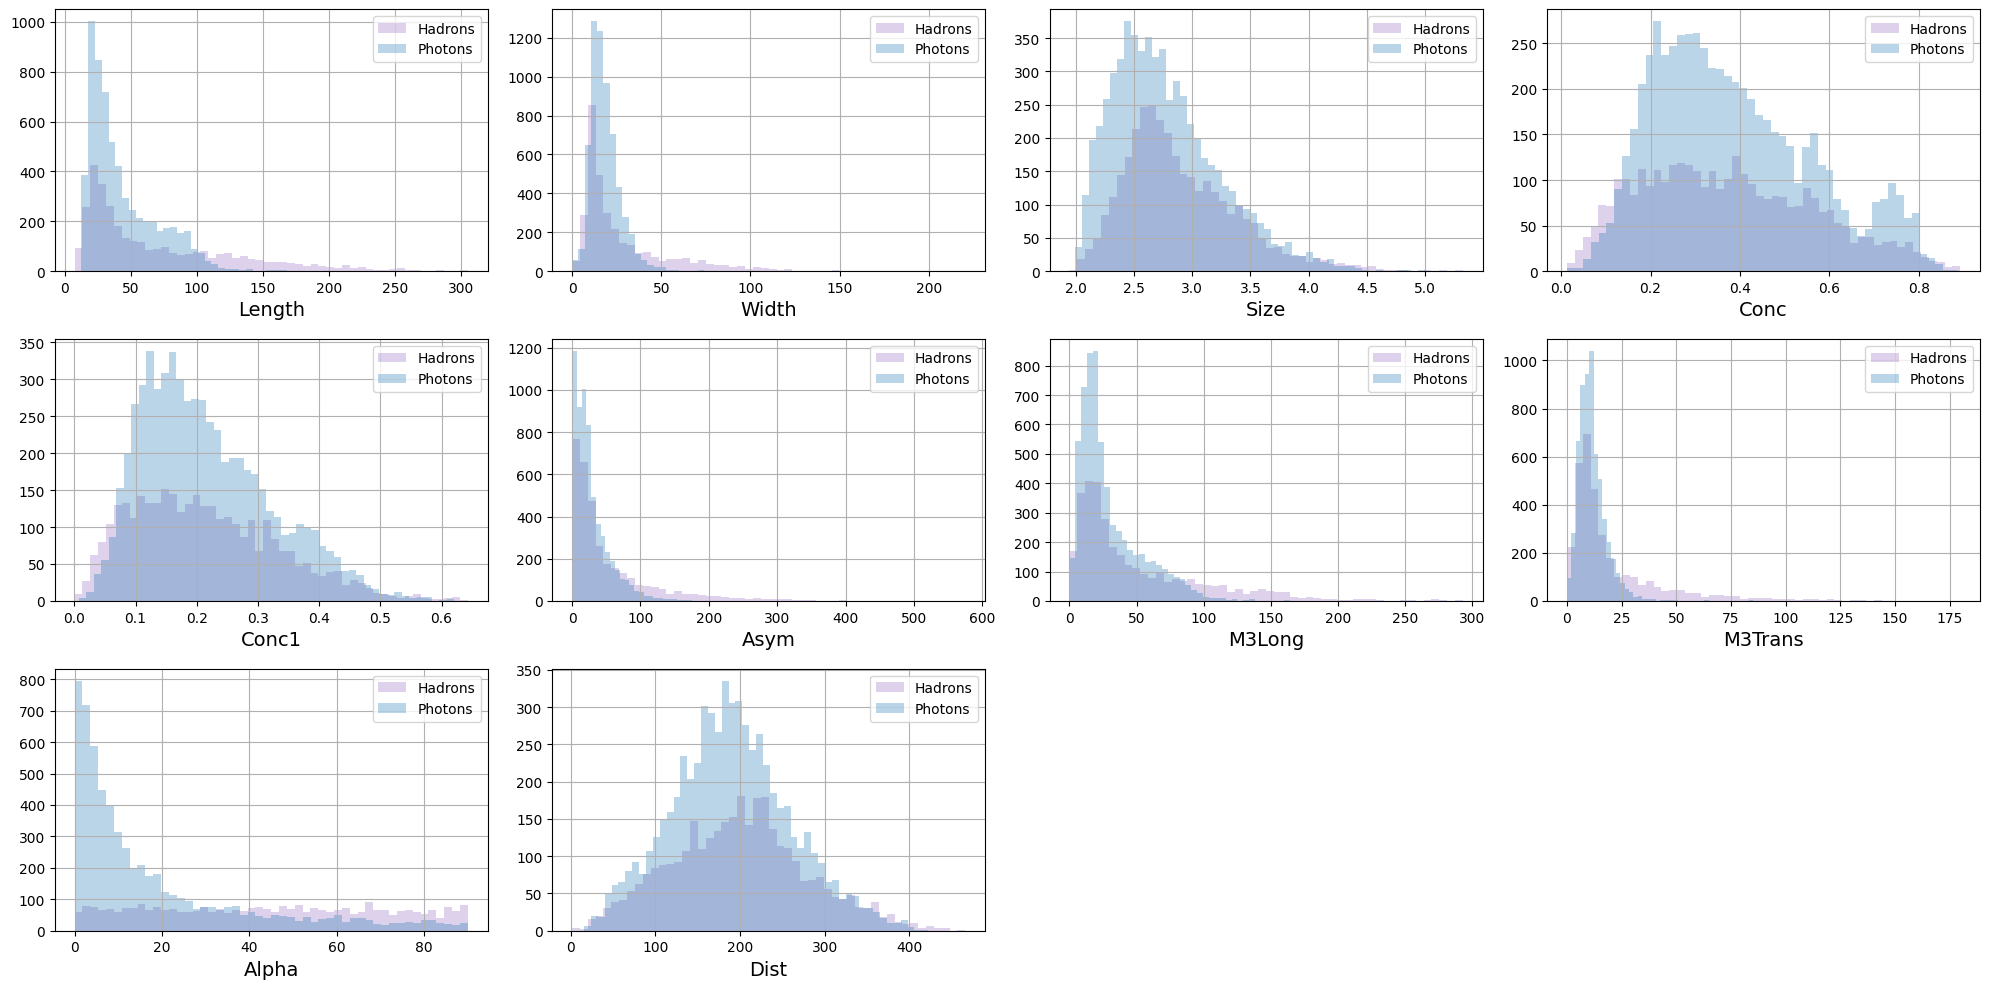

In [14]:
plot_hists(
    X_test[y_test[:, 0] == 0], X_test[y_test[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [15]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(
    n_quantiles=500, output_distribution="normal", random_state=666
)
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)

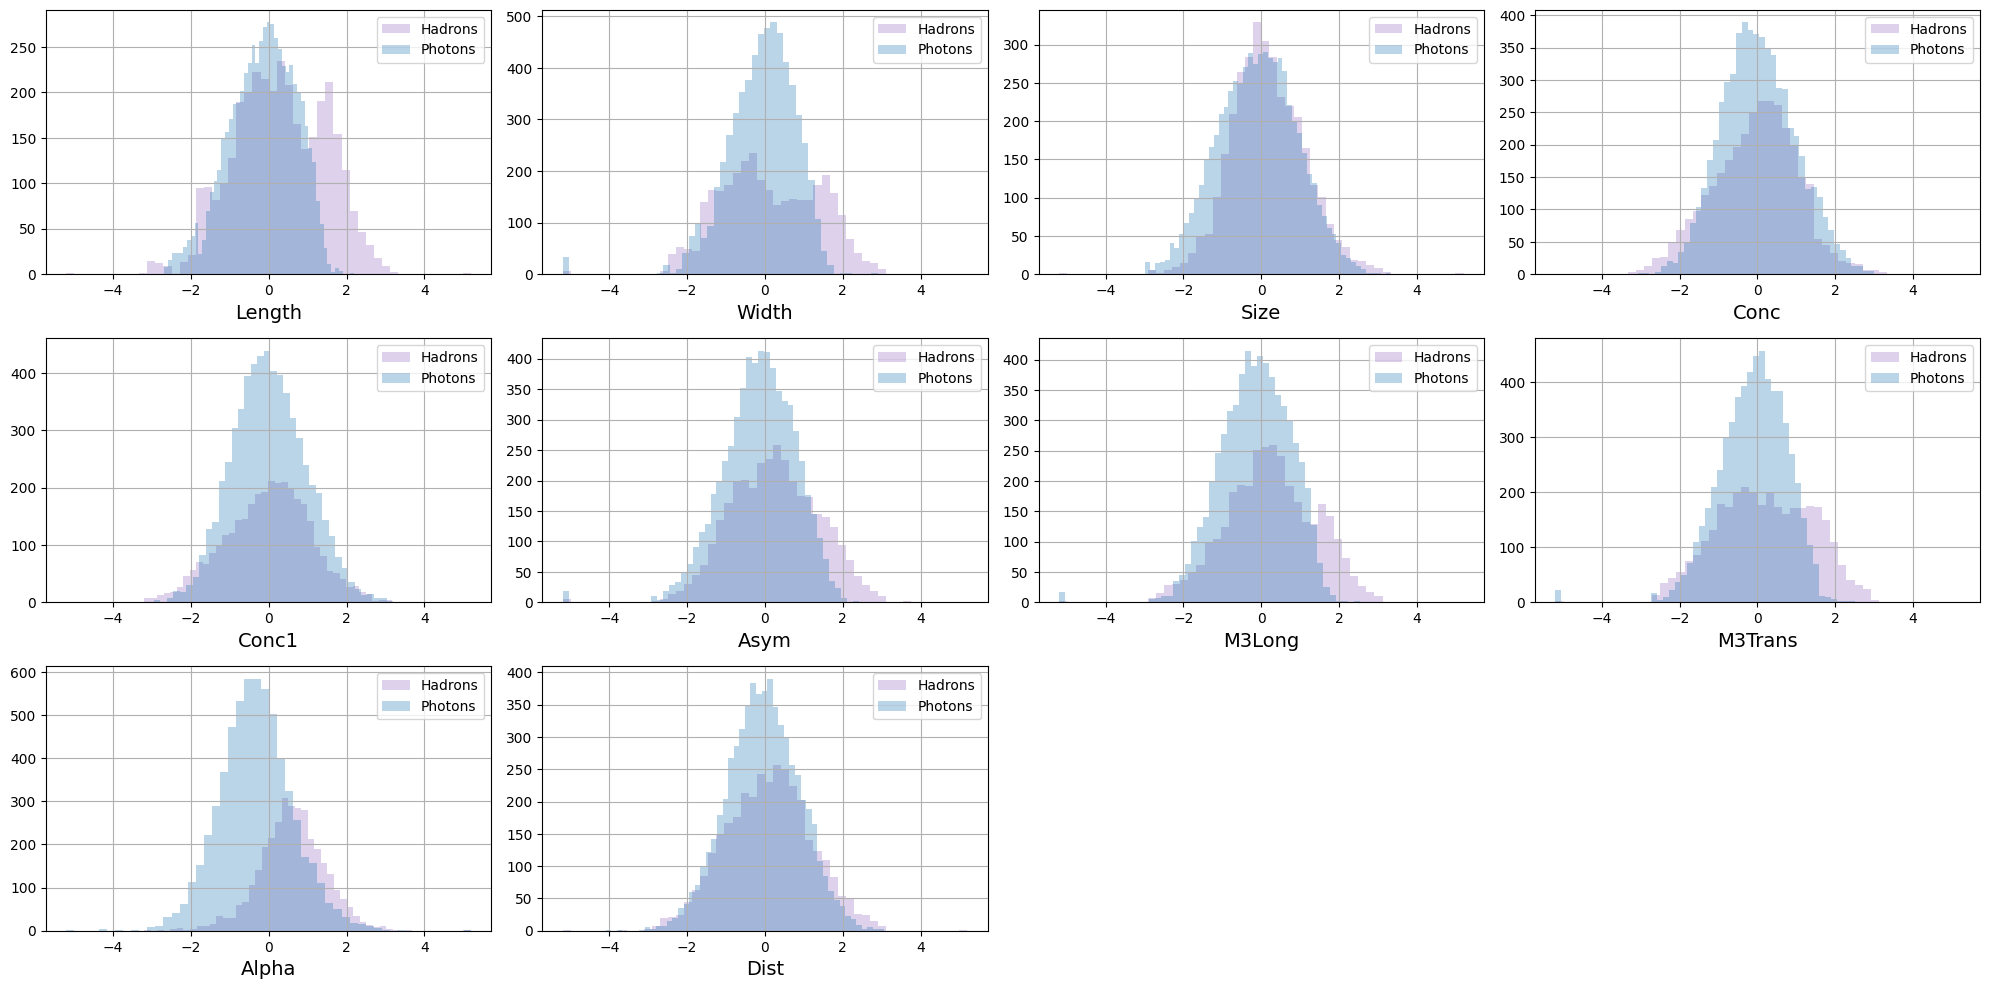

In [16]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

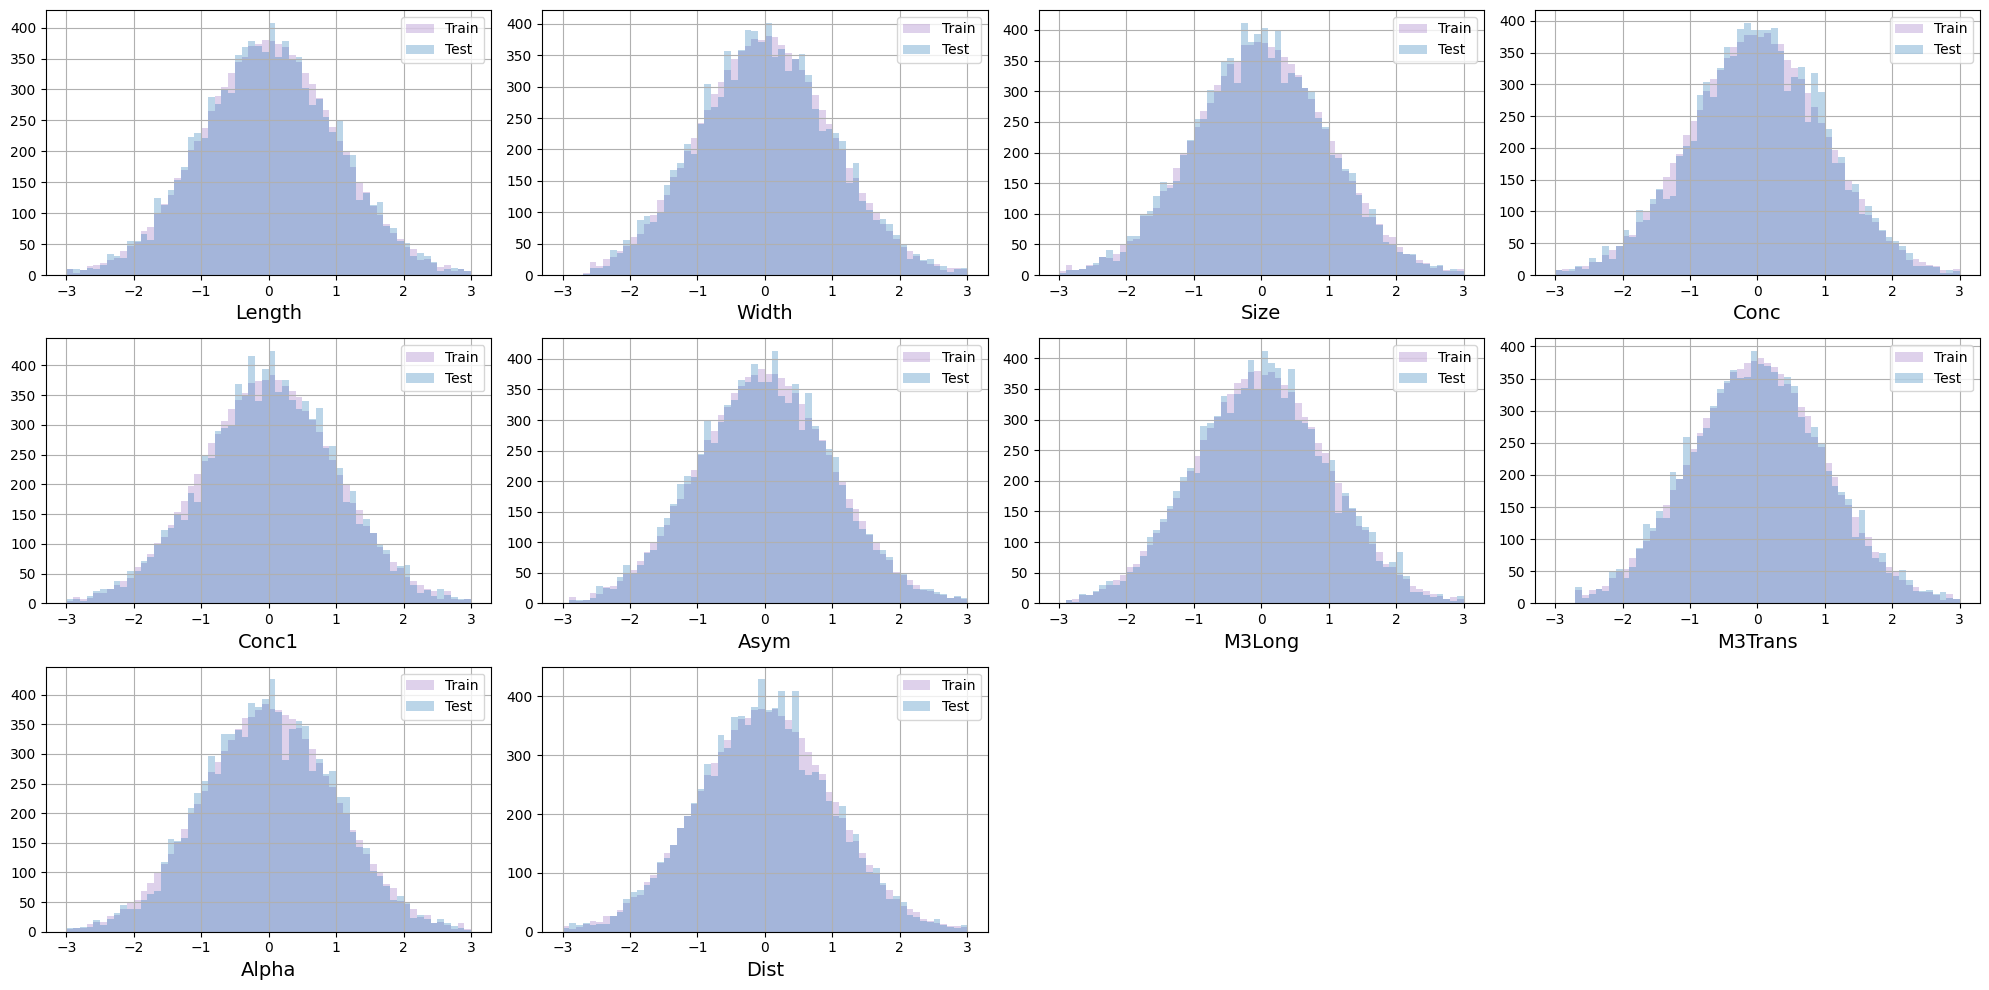

In [17]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
DEVICE

device(type='cuda')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [60]:
class Generator(nn.Module):
    def __init__(self, n_inputs, hidden_layers, n_outputs):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_inputs, hidden_layers),
            nn.BatchNorm1d(hidden_layers),
            nn.ReLU(),
            nn.Linear(hidden_layers, hidden_layers),
            nn.BatchNorm1d(hidden_layers),
            nn.ReLU(),
            nn.Linear(hidden_layers, n_outputs)
        )

    def forward(self, z, y):
        y = torch.tensor(y, dtype=torch.float, device=DEVICE)
        # concatenating noise vector z with the given condition
        zy = torch.cat((z.to(DEVICE), y), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [55]:
def generate(generator, y, latent_dim):
    batch_size = y.shape[0]
    Z_noise = torch.randn(batch_size, latent_dim).to(DEVICE)

    with torch.no_grad():
        X_fake = generator.forward(Z_noise, y) # obj generation

    return X_fake.cpu().numpy()  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

**Ответ:** нам не нужна функция активации (в оригинальном GAN используется сигмоида), так как дискриминатор WGAN'а аппроксимирует расстояние Вассерштайна, т.е. мы имеем дело с задачей регрессии. Поэтому выход -- действительное число.

In [56]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs, hidden_layers):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_inputs, hidden_layers),
            nn.ReLU(),
            nn.Linear(hidden_layers, hidden_layers),
            nn.ReLU(),
            nn.Linear(hidden_layers, 1),
        )

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1).to(DEVICE)
        return self.net(xy)

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

**Ответ:** в районе 0.5, чтобы конструкция из соревнующихся генератора и дискриминатора не развалилась. Семинарист проводил как-то аналогию между соревнующимися монетным двором и фальшивомонетчиками. Если одна из сторон вдруг получит доступ к технологиям чеканки монет из будущего, то вторая останется беззащитной и ничего не сможет противопоставить оппоненту. С генератором и дискриминатором та же история)

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

def other_agent_score(X_real, y_real, X_fake, y_fake):
    X, y = np.concatenate((X_real, X_fake), axis=0), np.concatenate((y_real, y_fake), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        stratify=y,
                                                        random_state=666)

    log_clf = LogisticRegression(random_state=666).fit(X_train, y_train)
    log_preds = log_clf.predict(X_test)
    log_reg_score = accuracy_score(log_preds, y_test)

    boost_clf = GradientBoostingClassifier(random_state=666).fit(X_train, y_train)
    boost_preds = boost_clf.predict(X_test)
    boost_score = accuracy_score(boost_preds, y_test)

    print(f"Logistic regression score: {log_reg_score}")
    print(f"Boosting score: {boost_score}")

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [72]:
class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######

                # training Discriminator
                for _ in range(self.n_critic):
                  self.opt_disc.zero_grad()

                  # generate fake data
                  # Z_noise = torch.normal(0, 1, (len(real_batch), self.latent_dim)).to(DEVICE)
                  Z_noise = torch.randn((len(real_batch), self.latent_dim)).to(DEVICE)
                  X_fake = self.generator(Z_noise, cond_batch)
                  # print(X_fake.dtype)  -> it's already a tensor

                  # forward pass: calculate loss function
                  loss_discriminator = -torch.mean(self.discriminator(real_batch, cond_batch)) + torch.mean(self.discriminator(X_fake, cond_batch))

                  # backpropagation and weight update
                  loss_discriminator.backward()
                  self.opt_disc.step()

                  # clamp the weights according to the requirement in the task
                  for p in self.discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)

                # training Generator
                self.opt_gen.zero_grad()

                # generate fake data
                # Z_noise = torch.normal(0, 1, (len(real_batch), self.latent_dim)).to(DEVICE)
                Z_noise = torch.randn((len(real_batch), self.latent_dim)).to(DEVICE)
                X_fake = self.generator(Z_noise, cond_batch)

                # forward pass: calculate generator loss
                gen_loss = -torch.mean(self.discriminator(X_fake, cond_batch))

                # backpropagation and weight update
                gen_loss.backward()
                self.opt_gen.step()

                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            X_fake_samples = generate(self.generator, y_cond[:1000], self.latent_dim)
            X_real_samples = X_real[:1000].cpu().numpy()

            # launching other_agent_score function
            other_agent_score(X_real_samples, np.ones(len(X_real_samples)), X_fake_samples, np.zeros(len(X_fake_samples)))
            print(f"Loss after {epoch+1} epoch is: {loss_epoch}")
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [74]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], hidden_layers=100, n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1], hidden_layers=100)

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 1 epoch is: 4.466651916503906


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 2 epoch is: 4.455264091491699


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 3 epoch is: 4.443716526031494


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 4 epoch is: 4.431357383728027


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 5 epoch is: 4.418942928314209


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 6 epoch is: 4.403590679168701


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 7 epoch is: 4.3882527351379395


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 8 epoch is: 4.370937347412109


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 9 epoch is: 4.355087757110596


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 10 epoch is: 4.339632034301758


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 11 epoch is: 4.3205060958862305


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 12 epoch is: 4.301400184631348


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 13 epoch is: 4.2789692878723145


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 14 epoch is: 4.262231826782227


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 15 epoch is: 4.2426652908325195


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 16 epoch is: 4.214569091796875


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 17 epoch is: 4.188454627990723


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 18 epoch is: 4.1670331954956055


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 19 epoch is: 4.143215179443359


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 20 epoch is: 4.1182332038879395


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 21 epoch is: 4.09361457824707


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 22 epoch is: 4.063048839569092


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 23 epoch is: 4.032272815704346


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 24 epoch is: 4.001518249511719


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 25 epoch is: 3.9760549068450928


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 26 epoch is: 3.940056800842285


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 27 epoch is: 3.906973361968994


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 28 epoch is: 3.868959903717041


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 29 epoch is: 3.8340232372283936


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 30 epoch is: 3.806180715560913


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 31 epoch is: 3.762424945831299


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 32 epoch is: 3.731466770172119


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 33 epoch is: 3.695767879486084


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 34 epoch is: 3.651163339614868


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 35 epoch is: 3.6225168704986572


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 36 epoch is: 3.5783958435058594


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 37 epoch is: 3.541736364364624


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 38 epoch is: 3.507214307785034


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 39 epoch is: 3.4645886421203613


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 40 epoch is: 3.42327880859375


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 41 epoch is: 3.386798143386841


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 42 epoch is: 3.341506004333496


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 43 epoch is: 3.2734551429748535


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 44 epoch is: 3.2531843185424805


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 45 epoch is: 3.2054734230041504


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 46 epoch is: 3.15567684173584


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 47 epoch is: 3.113478183746338


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 48 epoch is: 3.061730146408081


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 49 epoch is: 3.0106940269470215


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 50 epoch is: 2.9688267707824707


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 51 epoch is: 2.9189579486846924


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 52 epoch is: 2.8639183044433594


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 53 epoch is: 2.8148484230041504


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 54 epoch is: 2.7573723793029785


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 55 epoch is: 2.7025513648986816


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 56 epoch is: 2.6473782062530518


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 57 epoch is: 2.5891921520233154


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 58 epoch is: 2.542194128036499


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 59 epoch is: 2.484076499938965


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 60 epoch is: 2.414612054824829


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 61 epoch is: 2.3700969219207764


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 62 epoch is: 2.3065130710601807


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 63 epoch is: 2.2405810356140137


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 64 epoch is: 2.1824004650115967


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 65 epoch is: 2.1212265491485596


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 0.998
Loss after 66 epoch is: 2.068622589111328


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 67 epoch is: 2.0057244300842285


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 68 epoch is: 1.9328162670135498


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 69 epoch is: 1.8741686344146729


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 70 epoch is: 1.8040776252746582


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 71 epoch is: 1.7337985038757324


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 72 epoch is: 1.6720476150512695


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 73 epoch is: 1.5998432636260986


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 74 epoch is: 1.542259693145752


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 75 epoch is: 1.4777238368988037


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 76 epoch is: 1.440265417098999


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 77 epoch is: 1.3734009265899658


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 78 epoch is: 1.307856798171997


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 79 epoch is: 1.2390308380126953


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 80 epoch is: 1.170689582824707


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 81 epoch is: 1.0917954444885254


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 82 epoch is: 1.0297129154205322


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 83 epoch is: 0.9581305980682373


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 84 epoch is: 0.8916866779327393


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 0.996
Loss after 85 epoch is: 0.8205752372741699


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 86 epoch is: 0.746971607208252


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 87 epoch is: 0.6729457378387451


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 88 epoch is: 0.5908658504486084


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 89 epoch is: 0.5164878368377686


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 90 epoch is: 0.43720245361328125


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 91 epoch is: 0.3703165054321289


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 92 epoch is: 0.3105814456939697


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 93 epoch is: 0.2796553373336792


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 94 epoch is: 0.2406449317932129


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 95 epoch is: 0.19782590866088867


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 96 epoch is: 0.13968539237976074


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 97 epoch is: 0.0996323823928833


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 98 epoch is: 0.0653839111328125


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.932
Boosting score: 1.0
Loss after 99 epoch is: 0.009686782956123352


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression score: 0.976
Boosting score: 1.0
Loss after 100 epoch is: 0.11663701385259628
CPU times: user 5min 58s, sys: 17.5 s, total: 6min 16s
Wall time: 6min 8s


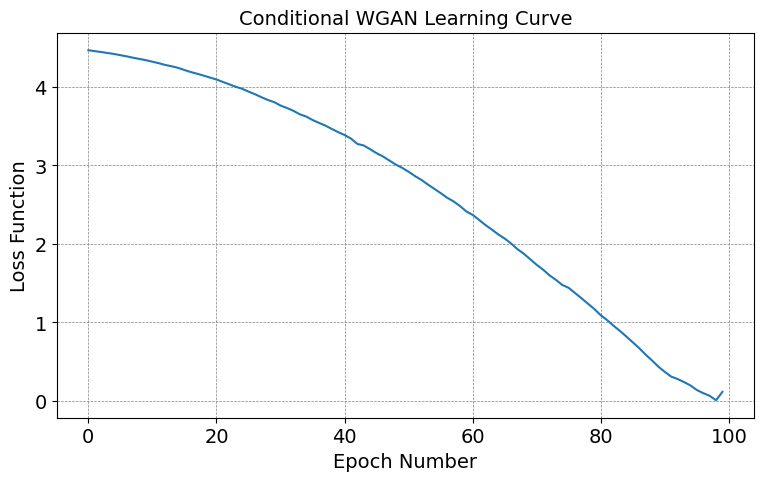

In [75]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [76]:
X_train = qt.inverse_transform(X_train)
X_test = qt.inverse_transform(X_test)
y_train.shape[0]
y_train.dtype

dtype('float64')

In [77]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)
X_fake_train = qt.inverse_transform(X_fake_train)

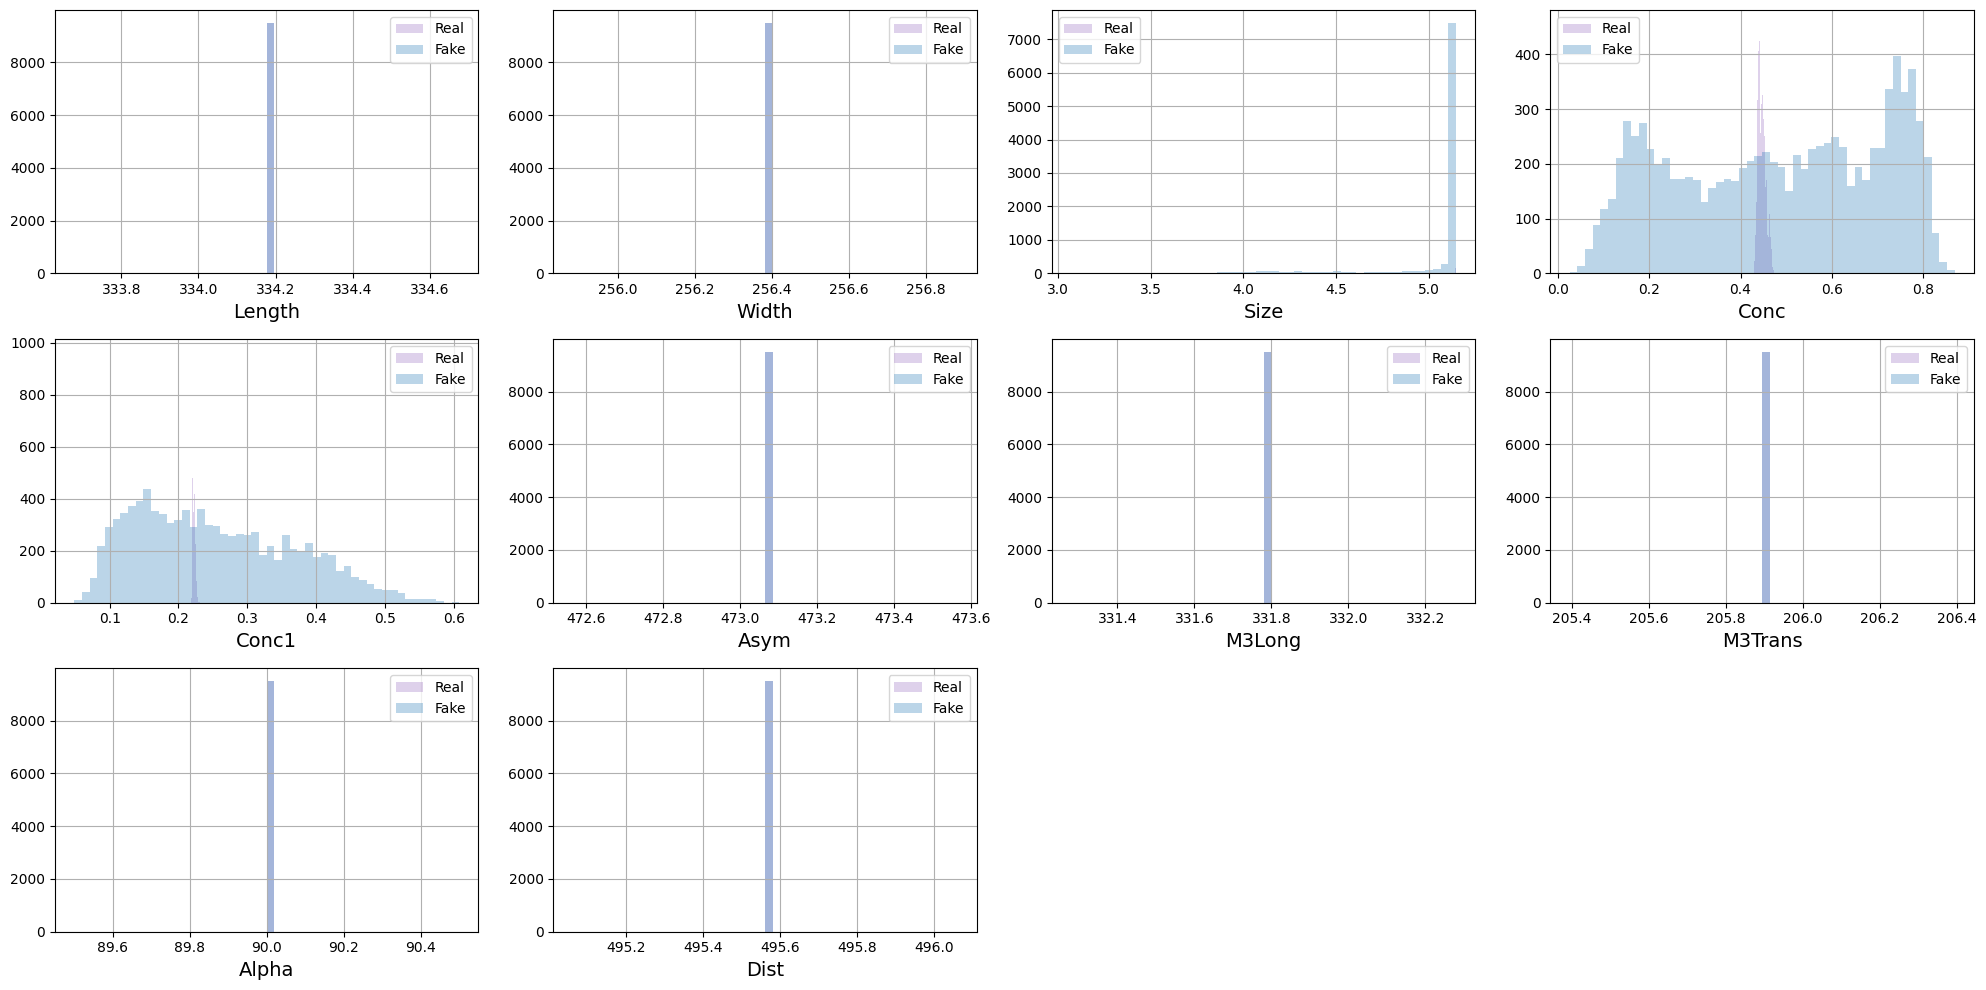

In [78]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [79]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)
X_fake_test = qt.inverse_transform(X_fake_test)

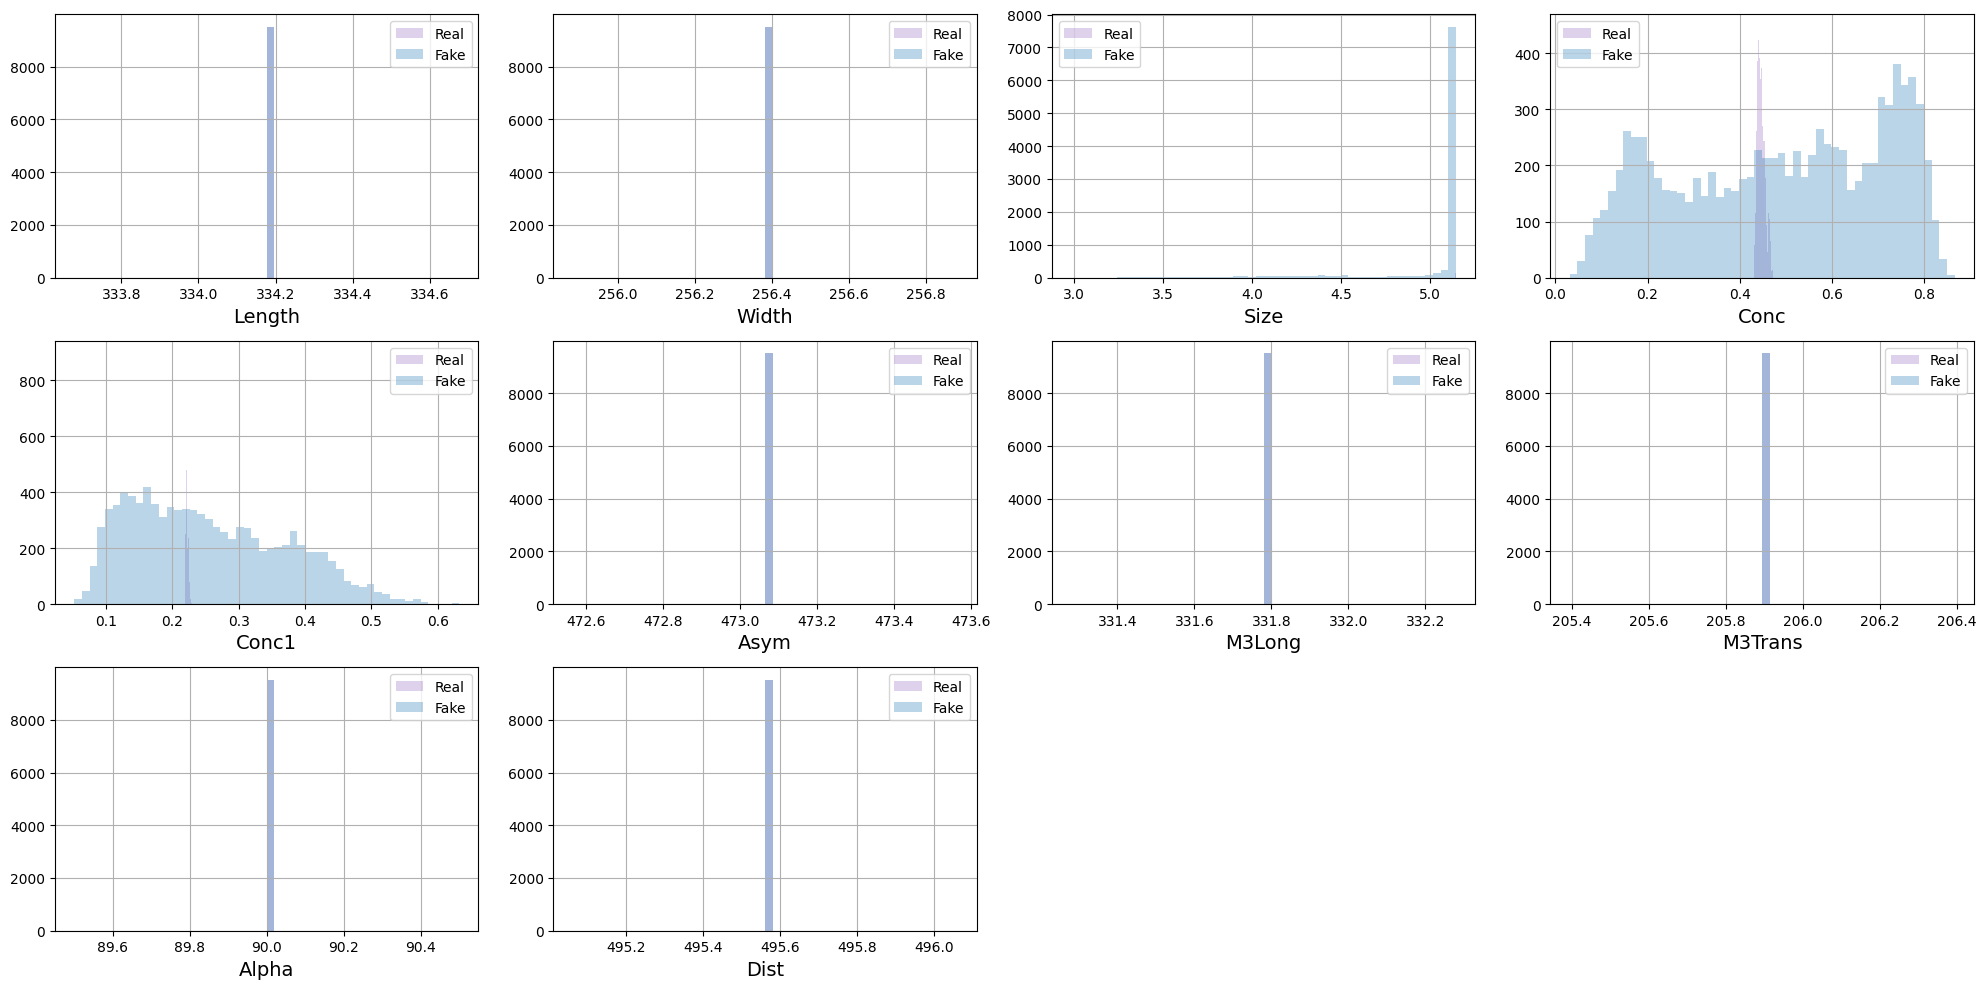

In [80]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод:
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [81]:
# собираем реальные и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [82]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [83]:
from sklearn.metrics import roc_auc_score, accuracy_score

roc_auc = roc_auc_score(yy_test, yy_test_proba)
print(f'{roc_auc=}', )

roc_auc=0.9999947921331356


In [84]:
yy_test_pred = clf.predict(XX_test)
accuracy = accuracy_score(yy_test, yy_test_pred)
print(f'{accuracy=}')

accuracy=0.9995268138801262


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?


Результаты удовлетворительные. Значение ROC AUC, которое удовлетворило бы нас больше всего -- 0.75. Здесь руководствуемся той же особенностью GAN'ов, что и в рассуждениях с Accuracy, но помним про специфику ROC AUC. Значение 0.5 при решении задачи классификации эквивалентно подбрасыванию монетки. Значение менее 0.5 (например, 0.1) свидетельствует о том, что при решении задачи бинарной классификации инверсия меток (0 на 1, а 1 на 0) радикально бы увеличила значение метрики (т.е. до 0.9).

Перевес по Accuracy в большую сторону (0.65) говорит о наличии дизбаланса в обучении генератора и дискриминатора.

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

In [85]:
!pip install diffusers -q

In [86]:
from diffusers import DDPMScheduler

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [87]:
X_train.shape[1]

10

In [88]:
def corrupt(x: torch.Tensor, amount: torch.Tensor) -> torch.Tensor:
    noise = torch.rand_like(x)
    amount = amount.view(-1, X_train.shape[1], 1, 1)

    # the second value is 10 because of
    # the number of features in X

    return x * (1 - amount) + noise * amount

## Добавим sсheduler, он пригодится вам при обучении модели

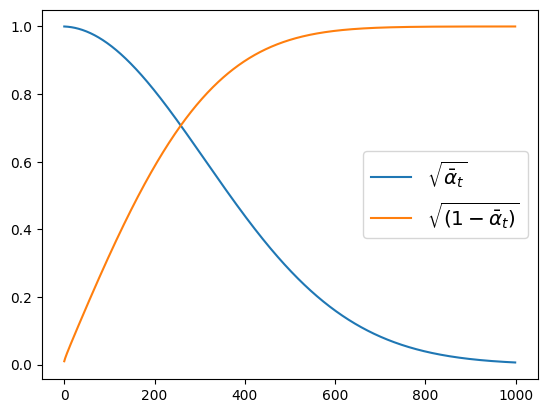

In [89]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [90]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, hidden_layers, n_outputs):
        super(DiffusionGenerator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n_inputs, hidden_layers),
            nn.BatchNorm1d(hidden_layers),
            nn.ReLU(),
            nn.Linear(hidden_layers, hidden_layers),
            nn.BatchNorm1d(hidden_layers),
            nn.ReLU(),
            nn.Linear(hidden_layers, n_outputs)
        )

    def forward(self, z, y):
        # converting to tensor
        y = torch.tensor(y, dtype=torch.float, device=DEVICE)
        # concatenating noise vector z with the given condition
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [91]:
def generate_with_diffusion(model, y, latent_dim, scheduler):
    model.eval()
    # generating noise
    batch_size = y.shape[0]
    Z_noise = torch.randn(batch_size, latent_dim).to(DEVICE)

    # generating fake objects with model
    with torch.no_grad():
      X_fake = model(Z_noise, y)

    # using scheduler for diffusion process
    timesteps = torch.linspace(0, 999, batch_size).long().to(DEVICE)
    noise = torch.randn_like(X_fake) # noise generation
    X_fake = scheduler.add_noise(X_fake, noise, timesteps)

    return X_fake.cpu().numpy()

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [92]:
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):

        self.model = generator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):
                self.opt_gen.zero_grad()

                # generate noise
                noise = torch.randn_like(real_batch)

                # generate fake data
                Z_noise = torch.randn((len(real_batch), self.latent_dim)).to(DEVICE)
                X_fake = self.model(Z_noise, cond_batch)

                # add noise using the approach from the seminar
                timesteps = torch.linspace(0, 999, real_batch.shape[0]).long().to(DEVICE)
                X_fake_noisy = noise_scheduler.add_noise(X_fake, noise, timesteps)

                # calculate loss
                loss = F.mse_loss(X_fake_noisy, noise)  # we're trying to predict the amount of noise (!)

                # backpropagation
                loss.backward()
                self.opt_gen.step()

                loss_epoch += loss.item()

            # caiculate and store loss after an epoch
            self.loss_history.append(loss_epoch)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            X_fake_samples = generate_with_diffusion(self.model, y_cond[:1000], self.latent_dim, noise_scheduler)
            X_real_samples = X_real[:1000].cpu().numpy()

            # launching other_agent_score function
            other_agent_score(X_real_samples, np.ones(len(X_real_samples)), X_fake_samples, np.zeros(len(X_fake_samples)))
            print(f"Loss after {epoch+1} epoch is: {loss_epoch}")

        # Turn off training
        self.model.train(False)

In [93]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], hidden_layers=100, n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
diffusionFitter.fit(X_train, y_train)

<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 1 epoch is: 3934870.189453125


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 2 epoch is: 888953.3040161133


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 3 epoch is: 83326.42733192444


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 4 epoch is: 19612.848765850067


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 5 epoch is: 5860.2514717280865


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 6 epoch is: 2553.75017157197


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 7 epoch is: 612.8327797353268


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 8 epoch is: 404.03046134114265


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 9 epoch is: 363.6350057423115


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 10 epoch is: 208.47454351186752


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 11 epoch is: 82.77383127808571


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 12 epoch is: 132.92166796326637


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 13 epoch is: 89.13968586921692


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 14 epoch is: 73.73851597309113


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 15 epoch is: 73.33877736330032


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 16 epoch is: 68.24114483594894


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 17 epoch is: 66.83335471153259


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 18 epoch is: 85.614921271801


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 19 epoch is: 62.740621238946915


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 20 epoch is: 61.64936563372612


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 21 epoch is: 60.47515848278999


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 22 epoch is: 59.046740144491196


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 23 epoch is: 67.16926297545433


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 24 epoch is: 57.580431669950485


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 25 epoch is: 55.87011760473251


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 26 epoch is: 56.02819503843784


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 27 epoch is: 54.376075118780136


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 28 epoch is: 53.21634963154793


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 29 epoch is: 52.117629408836365


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 30 epoch is: 51.6127544939518


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 31 epoch is: 50.64055743813515


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 32 epoch is: 49.165104538202286


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 33 epoch is: 48.117619425058365


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 34 epoch is: 47.34117168188095


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 35 epoch is: 46.544283241033554


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 36 epoch is: 45.091041550040245


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 37 epoch is: 44.421535328030586


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 38 epoch is: 43.82299646735191


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 39 epoch is: 43.34255112707615


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 40 epoch is: 42.33256162703037


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 41 epoch is: 42.286103546619415


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 42 epoch is: 40.91952635347843


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 43 epoch is: 40.0730415135622


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 44 epoch is: 39.534083276987076


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 45 epoch is: 39.08160591125488


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 46 epoch is: 37.68908889591694


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 47 epoch is: 37.758427023887634


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 48 epoch is: 36.68695244193077


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 49 epoch is: 36.24091297388077


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 50 epoch is: 35.48579539358616


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 51 epoch is: 34.78498373925686


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 52 epoch is: 33.73751913011074


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 53 epoch is: 33.55853356420994


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 54 epoch is: 32.71909964829683


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 55 epoch is: 32.95071506500244


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 56 epoch is: 32.42419262230396


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 57 epoch is: 31.757375456392765


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 58 epoch is: 31.275127165019512


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 59 epoch is: 31.037487491965294


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 60 epoch is: 30.42011286318302


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 61 epoch is: 29.74849132448435


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 62 epoch is: 29.848026514053345


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 63 epoch is: 29.862249933183193


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 64 epoch is: 29.10805071890354


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 65 epoch is: 28.94385050982237


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 66 epoch is: 28.338606856763363


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 67 epoch is: 28.25229461491108


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 68 epoch is: 27.633388102054596


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 69 epoch is: 27.424563512206078


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 70 epoch is: 27.195870272815228


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 71 epoch is: 26.81923221051693


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 72 epoch is: 26.614788129925728


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 73 epoch is: 26.425496965646744


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 74 epoch is: 25.974489636719227


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 75 epoch is: 25.982052326202393


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 76 epoch is: 25.916002482175827


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 77 epoch is: 25.663944765925407


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 78 epoch is: 25.26293743401766


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 79 epoch is: 25.4273879006505


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 80 epoch is: 25.335952706635


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 81 epoch is: 25.157402835786343


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 82 epoch is: 24.74435544759035


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 83 epoch is: 24.313427045941353


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 84 epoch is: 24.66766105592251


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 85 epoch is: 24.674483120441437


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 86 epoch is: 24.302948489785194


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 87 epoch is: 23.78599452227354


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 88 epoch is: 24.350984394550323


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 89 epoch is: 24.235947355628014


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 90 epoch is: 24.07670246809721


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 91 epoch is: 23.512027859687805


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 92 epoch is: 23.33531992137432


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 93 epoch is: 23.51635143905878


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 94 epoch is: 23.604408964514732


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 95 epoch is: 23.126069493591785


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 96 epoch is: 23.053305186331272


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 97 epoch is: 23.803961515426636


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 98 epoch is: 23.508748315274715


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 99 epoch is: 23.080311976373196


<ipython-input-60-16fb4c608e98>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic regression score: 1.0
Boosting score: 1.0
Loss after 100 epoch is: 23.187411822378635
CPU times: user 1min 15s, sys: 11.5 s, total: 1min 27s
Wall time: 1min 24s


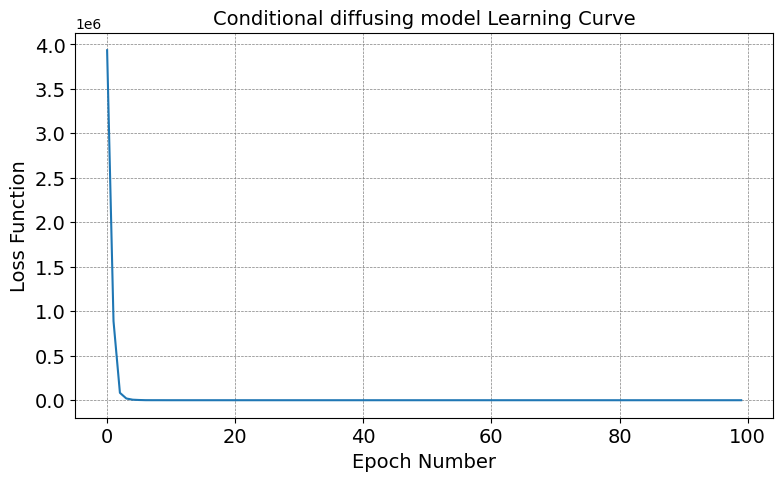

In [94]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [95]:
X_fake_train = generate_with_diffusion(diffusionFitter.model, y_train, latent_dim, noise_scheduler)
X_fake_test = generate_with_diffusion(diffusionFitter.model, y_test, latent_dim, noise_scheduler)

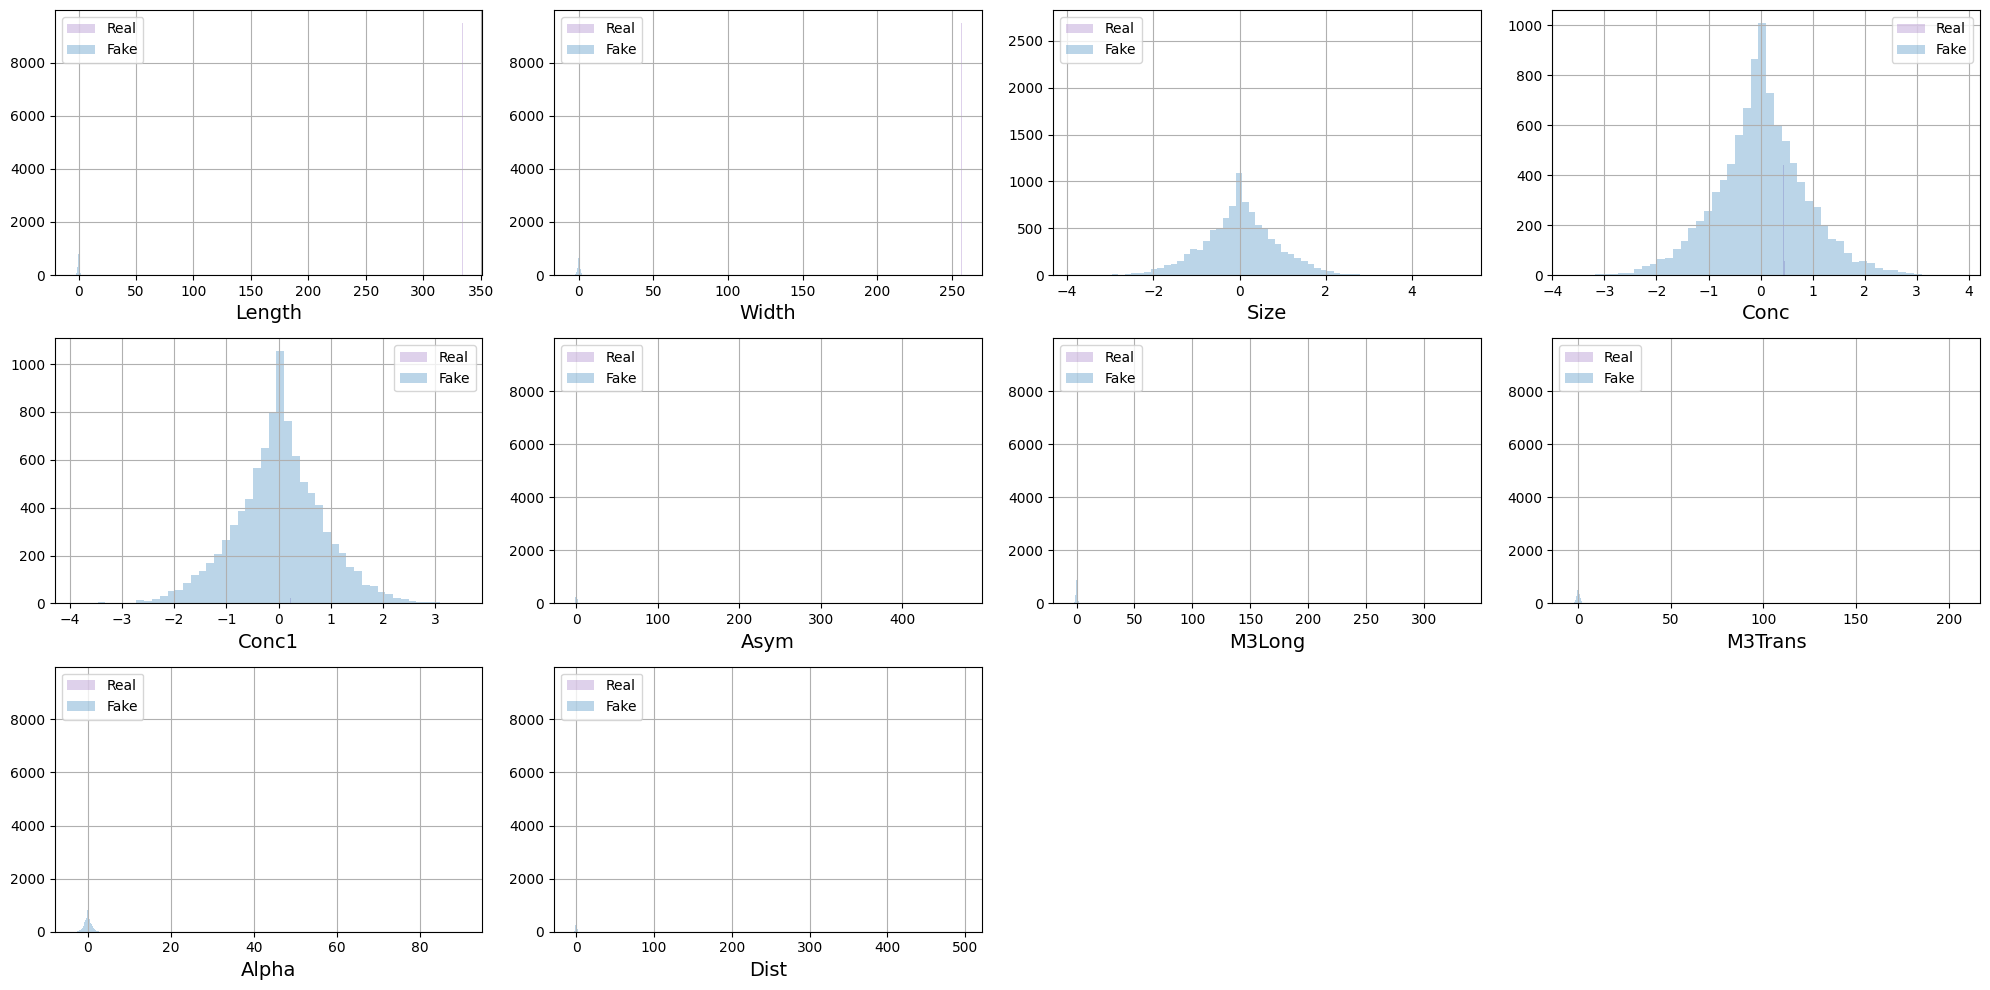

In [96]:
# Illustrating results before inverse transformation
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

In [97]:
X_fake_train, X_fake_test = qt.inverse_transform(X_fake_train), qt.inverse_transform(X_fake_test)

X_train, X_test = qt.inverse_transform(X_train), qt.inverse_transform(X_test)

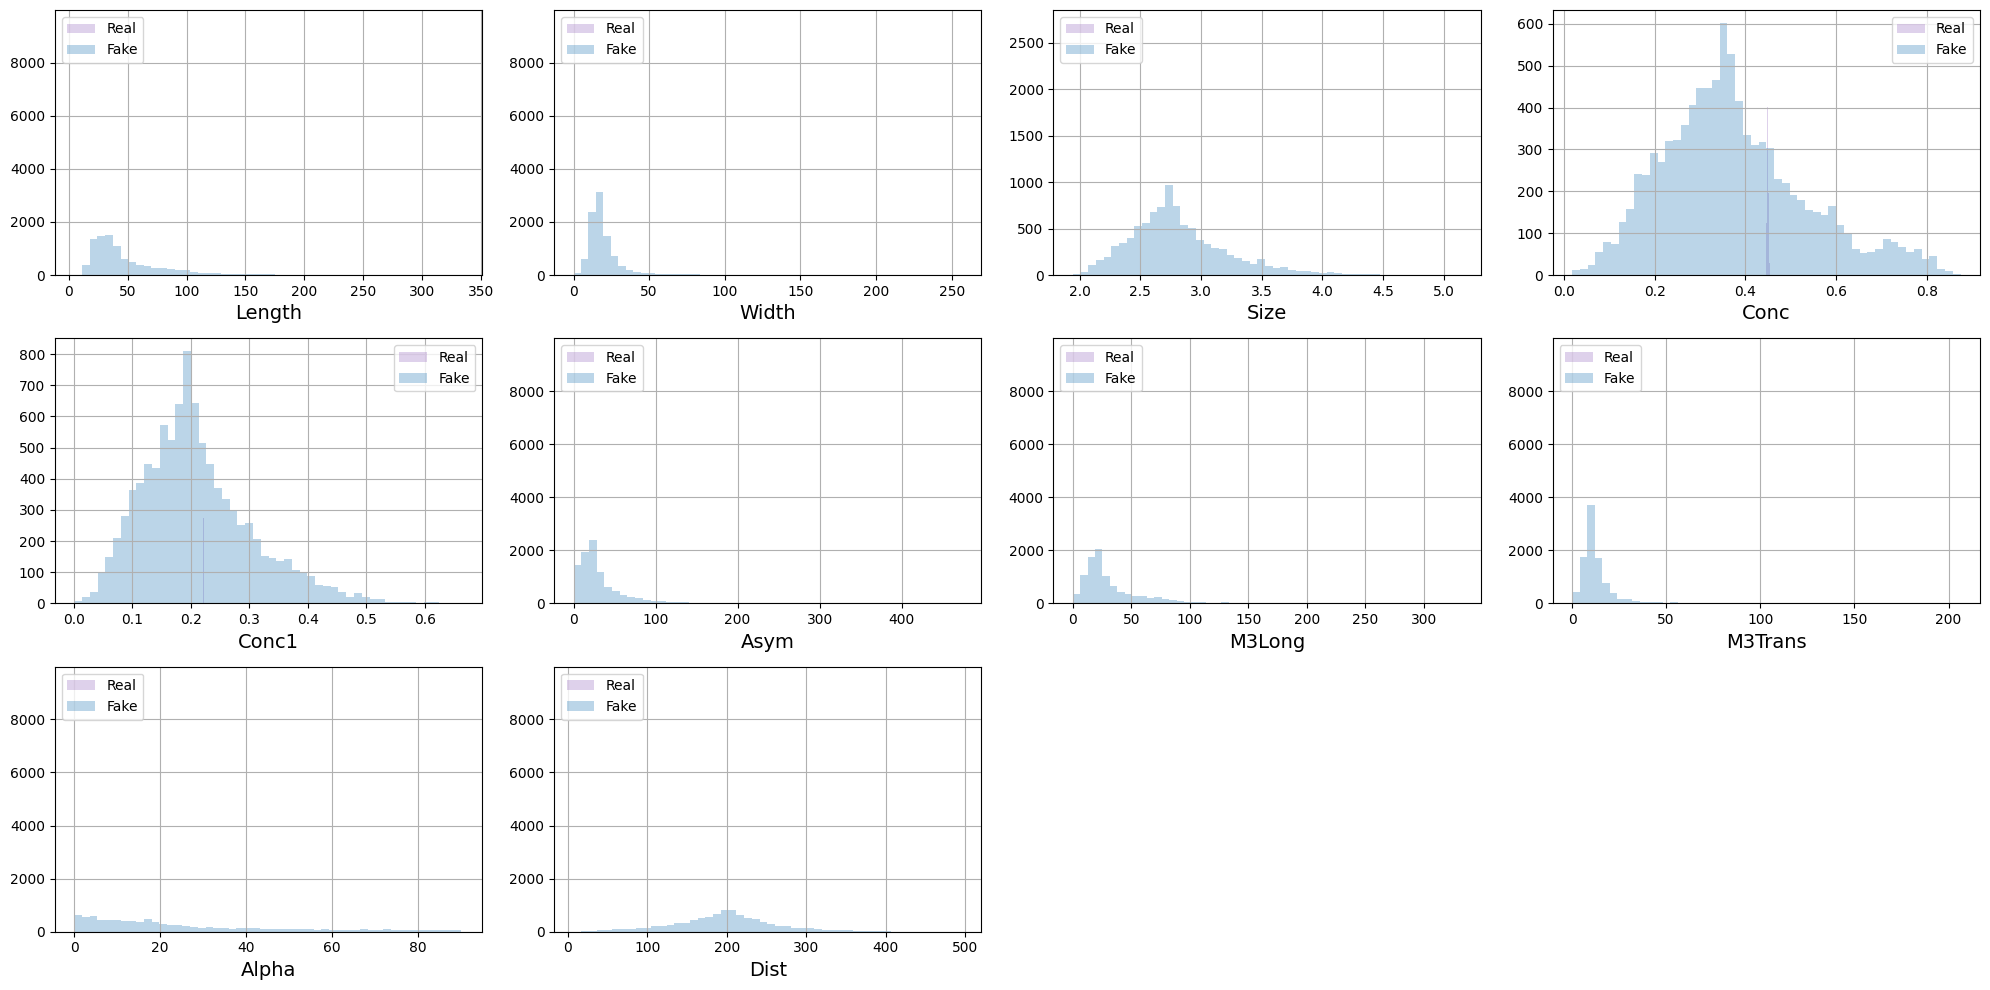

In [98]:
# illustrate after inverse quantile transformation
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

In [99]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))

In [100]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [101]:
auc_roc = roc_auc_score(yy_test, yy_test_proba)
print(f'{auc_roc=}')

auc_roc=1.0


In [102]:
yy_test_pred = clf.predict(XX_test)
accuracy = accuracy_score(yy_test, yy_test_pred)
print(f'{accuracy=}')

accuracy=1.0


Здесь мы получили очень хорошие значения. Следовательно, распределения фейковое и настоящее -- практически идентичны. Результаты GAN'а и диффузионной модели на данном датасете сопоставимы.